In [26]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from haystack.document_stores import InMemoryDocumentStore

# Here Here we initialize the DocumentStore to store 512 dim image embeddings
# obtained using OpenAI CLIP model
document_store = InMemoryDocumentStore(embedding_dim=512)

In [28]:
from haystack.utils import fetch_archive_from_http

doc_dir = "data/wikiarts"

#fetch_archive_from_http(
   # url="https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/spirit-animals.zip",
   # output_dir=doc_dir,)


Add the images you just downloaded into Haystack Document objects and write them into the DocumentStore.

In [29]:
import os

from haystack import Document

images = [
    Document(content=f"./{doc_dir}/wikiarts/{filename}", content_type="image")
    for filename in os.listdir(f"./{doc_dir}/wikiarts/")
]

document_store.write_documents(images)

You have successfully stored your images in the DocumentStore.



## Initializing the Retriever

Retrievers sift through all the images and return only those that are relevant to the query. To run a search on images, you'll use the MultiModalRetriever with the [OpenAI CLIP model](https://github.com/openai/CLIP/blob/main/model-card.md). 

For more details on supported modalities, see [MultiModalRetriever](https://docs.haystack.deepset.ai/docs/retriever#multimodal-retrieval).

Before adding the Retriever to your pipeline, let's configure its parameters

In [30]:
from haystack.nodes.retriever.multimodal import MultiModalRetriever

retriever_text_to_image = MultiModalRetriever(
    document_store=document_store,
    query_embedding_model="sentence-transformers/clip-ViT-B-32",
    query_type="text",
    document_embedding_models={"image": "sentence-transformers/clip-ViT-B-32"},
)

# Now let's turn our images into embeddings and store them in the DocumentStore.
document_store.update_embeddings(retriever=retriever_text_to_image)

Updating Embedding:   0%|          | 0/20 [00:00<?, ? docs/s]

Create embeddings:   0%|          | 0/2 [00:00<?, ? Docs/s]

 Your retriever is now ready for search!

## Creating the MultiModal Search Pipeline

We are populating a pipeline with a MultiModalRetriever node. This search pipeline queries the image database with text and returns the most relevant images.

In [34]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_node(component=retriever_text_to_image, name="retriever_text_to_image", inputs=["Query"])

Now, you have a pipeline that uses the MultiModalRetriever and takes a text query as input. Let's try it out.

## Searching Through the Images

Use the pipeline `run()` method to query the images in the DocumentStore. The query argument is where you type your text query. Additionally, you can set the number of images you want the MultiModalRetriever to return using the `top-k` parameter. To learn more about setting arguments, see [Pipeline Arguments](https://docs.haystack.deepset.ai/docs/pipelines#arguments).

In [35]:
results = pipeline.run(query="Animal that lives in Africa", params={"retriever_text_to_image": {"top_k": 5}})

# Sort the results based on the scores
results = sorted(results["documents"], key=lambda d: d.score, reverse=True)

for doc in results:
    print(doc.score, doc.content)

Create embeddings:   0%|          | 0/1 [00:00<?, ? Docs/s]

0.5711996283586808 ./data/wikiarts/wikiarts/coney-island-beauty-1974.jpg
0.5672528011116746 ./data/wikiarts/wikiarts/monet-house-of-parliament-sun.jpg
0.5633420727284799 ./data/wikiarts/wikiarts/bull-i-1930.jpg
0.5572764754594554 ./data/wikiarts/wikiarts/english-partridge-in-flight-1898.jpg
0.556592755938744 ./data/wikiarts/wikiarts/autoportrait-1971.jpg


vizualize these images together with their score:




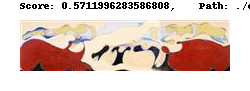

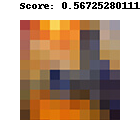

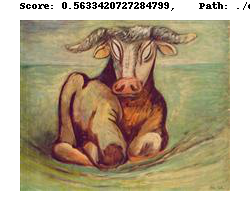

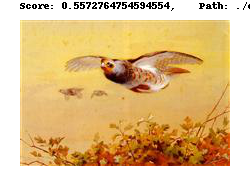

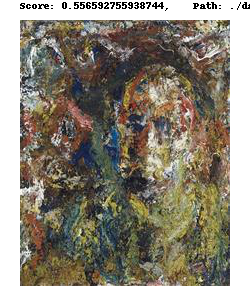

In [36]:
from io import BytesIO
from PIL import Image, ImageDraw, ImageOps
from IPython.display import display, Image as IPImage


def display_img_array(ima, score):
    im = Image.open(ima)
    img_with_border = ImageOps.expand(im, border=20, fill="white")

    # Add Text to an image
    img = ImageDraw.Draw(img_with_border)
    img.text((20, 0), f"Score: {score},    Path: {ima}", fill=(0, 0, 0))

    bio = BytesIO()
    img_with_border.save(bio, format="png")
    display(IPImage(bio.getvalue(), format="png"))


images_array = [doc.content for doc in results]
scores = [doc.score for doc in results]
for ima, score in zip(images_array, scores):
    display_img_array(ima, score)